<div style="color: #ffffff; background-color: #2979ff; border-bottom: 1px solid #004ecb; padding: 2em;">
<b style="font-size: 20pt;">ILLUIN TECHNOLOGY</b>
    
<b style="font-size: 20pt;">Détection d'intention dans un chatbot</b> <br> <br>
<b style="font-size: 14pt;">Andy Zhang</b>
</div>

Ce Notebook contient une seconde solution au problème proposé, en utilisant en particulier des modèles de Deep Learning et en particulier CamemBERT (Version française de BERT).

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # To display all the text

import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import Trainer, TrainingArguments

from utils import map_class_to_int, convert_class_name_to_id, display_all_results_dnn

<div>
<b style="font-size: 20pt;">DATA PRE-PROCESSING</b>
</div>

In [ ]:
# Load the data
data = pd.read_csv('intent-detection-train.csv')

In [ ]:
data.sample(n=10)

,text,label
426,Est-ce que vous pouvez me donner des informations sur les vols disponibles?,book_flight
244,"Je pense que mes bagages sont égarés, comment le vérifier?",lost_luggage
353,Pouvez-vous me renseigner sur les exigences pour les bagages à main en cabine?,carry_on
317,Quels sont les endroits idéaux pour des vacances de détente?,travel_suggestion
227,Est-ce que mon voyage en avion est en avance ou en retard?,flight_status
139,"Je vais bientôt voyager, devrais-je m'inquiéter de la situation?",travel_alert
202,Je veux vérifier si mon voyage est à l'heure.,flight_status
168,Je me demande s'il y a des problèmes de sécurité à ma destination.,travel_alert
171,"Je prévois de me rendre là-bas, mais je veux connaître la situation.",travel_alert
494,J'aimerais des conseils pour améliorer ma productivité au travail.,out_of_scope


In [ ]:
class_names = data.label.unique()
class_name_to_label, label_to_class_name = map_class_to_int(class_names)

data_texts = data['text'].to_list()
data_labels = data.label.copy()
data_labels = convert_class_name_to_id(data_labels, class_name_to_label)

nb_classes = len(np.unique(data_labels))

In [ ]:
# Train, Validation and Test splitting of the data
X_train_val, X_test, y_train_val, y_test = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42, stratify=data_labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/8, random_state=42, stratify=y_train_val)

In [ ]:
# Tokenization of the text data using the pretrained CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

X_train_encodings = tokenizer(X_train, truncation = True, padding = True)
X_val_encodings = tokenizer(X_val, truncation = True, padding = True)
X_test_encodings = tokenizer(X_test, truncation = True, padding = True)

X_train_encodings['label'] = y_train
X_val_encodings['label'] = y_val
X_test_encodings['label'] = y_test

X_train_dataset = Dataset.from_dict(X_train_encodings)
X_val_dataset = Dataset.from_dict(X_val_encodings)
X_test_dataset = Dataset.from_dict(X_test_encodings)

<div>
<b style="font-size: 20pt;">Model Training</b>
</div>

In [ ]:
trainings_args = TrainingArguments(
    output_dir='./results1',
    num_train_epochs=30,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    overwrite_output_dir=True,
    warmup_steps=200,
    weight_decay=1e-5,
    logging_dir='./logs',
    logging_steps=10
)

In [ ]:
model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels=nb_classes,
    id2label=label_to_class_name,
    label2id=class_name_to_label
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=trainings_args,
    train_dataset=X_train_dataset,
    eval_dataset=X_val_dataset,
    compute_metrics=compute_metrics,
)

<ipython-input-9-29cde1c561d6>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.197815,0.115385
2,2.197300,2.196115,0.115385
3,2.197300,2.193321,0.115385
4,2.194900,2.188928,0.115385
5,2.189200,2.182480,0.115385
6,2.189200,2.172076,0.326923
7,2.173700,2.153577,0.596154
8,2.173700,2.120709,0.711538
9,2.142000,2.069835,0.750000
10,2.080700,2.004222,0.826923


TrainOutput(global_step=180, training_loss=1.4412976079516941, metrics={'train_runtime': 59.4056, 'train_samples_per_second': 181.801, 'train_steps_per_second': 3.03, 'total_flos': 149859386344800.0, 'train_loss': 1.4412976079516941, 'epoch': 30.0})

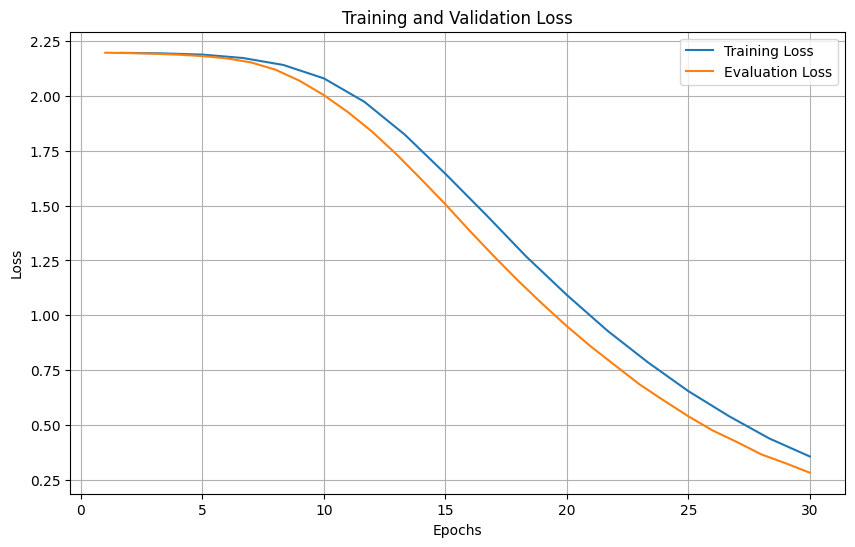

In [ ]:
# Plot the training and validation loss during the training
import matplotlib.pyplot as plt

train_history = [item for item in trainer.state.log_history if 'loss' in item]
eval_history = [item for item in trainer.state.log_history if 'eval_loss' in item]

train_loss = [item['loss'] for item in train_history]
eval_loss = [item['eval_loss'] for item in eval_history]

training_epochs = [item['epoch'] for item in train_history]
validation_epochs = [item['epoch'] for item in eval_history]

plt.figure(figsize=(10, 6))
plt.plot(training_epochs, train_loss, label='Training Loss')
plt.plot(validation_epochs, eval_loss, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('../docs/train_validation_loss.jpg', bbox_inches='tight', dpi=300)
plt.show()

<div>
<b style="font-size: 20pt;">Model Evaluation</b>
</div>

In [ ]:
results = trainer.predict(X_test_dataset)
results.metrics

{'test_loss': 0.3431767523288727,
 'test_accuracy': 0.970873786407767,
 'test_runtime': 0.1425,
 'test_samples_per_second': 722.829,
 'test_steps_per_second': 14.036}

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97
                   precision    recall  f1-score   support

        translate       1.00      1.00      1.00        12
     travel_alert       1.00      1.00      1.00        11
    flight_status       0.92      1.00      0.96        12
     lost_luggage       1.00      1.00      1.00        11
travel_suggestion       0.91      0.91      0.91        11
         carry_on       1.00      1.00      1.00        11
       book_hotel       1.00      1.00      1.00        11
      book_flight       1.00      1.00      1.00        11
     out_of_scope       0.92      0.85      0.88        13

         accuracy                           0.97       103
        macro avg       0.97      0.97      0.97       103
     weighted avg       0.97      0.97      0.97       103



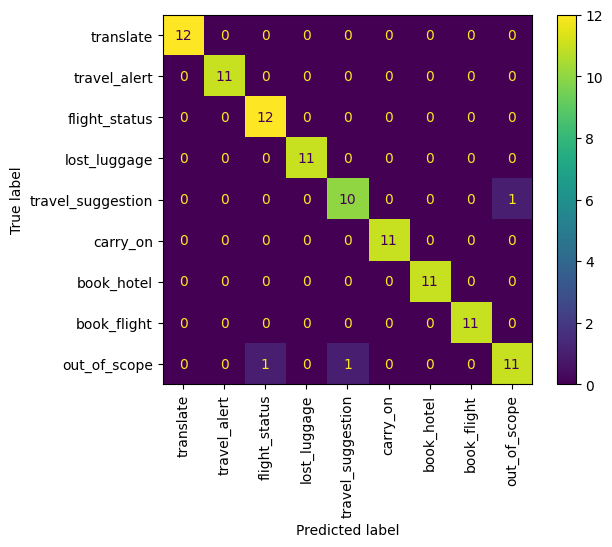

In [ ]:
y_test_pred = [np.argmax(text_pred) for text_pred in results.predictions]
display_all_results_dnn(y_test, y_test_pred, class_names)

In [ ]:
# Sample test
test_test = ["j'ai le droit d'avoir de l'eau sur moi ?"]
encoded_test = tokenizer(test_test, truncation=True, padding=True)
encoded_test_set = Dataset.from_dict(encoded_test)
results = trainer.predict(encoded_test_set)
print(model.config.id2label[np.argmax(results.predictions)])

carry_on


In [ ]:
# Save the model
saved_directory="./models"
model.save_pretrained(saved_directory)
tokenizer.save_pretrained(saved_directory)

('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/sentencepiece.bpe.model',
 './saved_models/added_tokens.json')